In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import torch
import torch.nn as nn

from instructor import Instructor
from qpnet import QpNet
from qpth.qp import QPFunction


plt.style.use('bmh')

# Load the dataset

In [2]:
# loads data from .mat file
# contains the initial state x0 and finite u series
mat = io.loadmat('./large.mat')  # or small.mat
x0 = np.transpose(mat['x'])
u = np.transpose(mat['u'])
print("shape of x0:",x0.shape," |shape of u:",u.shape)

shape of x0: (5831, 2)  |shape of u: (5831, 5)


### Input: x(0), output: u(0) 

In [3]:
# build input and output in tensor type
if torch.cuda.is_available():  # cuda or cpu
    Variable = lambda *args, **kwargs: \
        torch.autograd.Variable(*args, **kwargs).cuda()  # Variable: not require gra
else:
    Variable = lambda *args, **kwargs: \
        torch.autograd.Variable(*args, **kwargs)
x = Variable(torch.from_numpy(x0).float(), requires_grad=False)
y = Variable((torch.from_numpy(u[:,0])).float(), requires_grad=False)

# split the dataset into train and test
dataset = torch.utils.data.TensorDataset(x,y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("train size:",len(train_dataset)," |test size:",len(test_dataset))

# shuffle the data, build dataset batches
batch_size = 50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

train size: 4664  |test size: 1167


In [6]:
# Initialize the model.
dim_inp = x0.shape[1]
dim_out = 1
num_hid= 10
model = QpNet(dim_inp, dim_out, num_hid, bn=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fun = torch.nn.MSELoss() # Initialize the loss function

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses_train = []
losses_test = []
instructor = Instructor(model, optimizer, loss_fun)

# Train the data

In [7]:
for epoch in range(5):
    loss_train = instructor.train(train_loader,epoch)
    loss_test = instructor.evaluate(test_loader)
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    print('[epoch: %d] training loss: %.3f, testing loss: %.3f' %
                      (epoch + 1, loss_train, loss_test))

[epoch: 1] training loss: 0.185, testing loss: 0.058
[epoch: 2] training loss: 0.070, testing loss: 0.035
[epoch: 3] training loss: 0.045, testing loss: 0.021
[epoch: 4] training loss: 0.046, testing loss: 0.014
[epoch: 5] training loss: 0.040, testing loss: 0.012


(0.0, 0.19375230753794312)

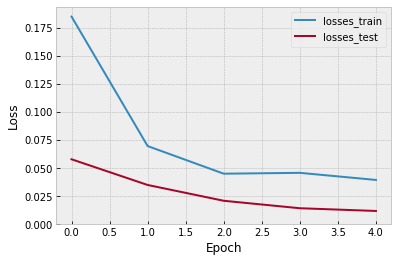

In [8]:
plt.plot(losses_train, label='losses_train')
plt.plot(losses_test, label='losses_test')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(ymin=0.)

In [9]:
model.A

tensor([[-0.7396, -0.1756],
        [-0.0283,  0.3965]], device='cuda:0', grad_fn=<CopyBackwards>)